In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def build_generator(latent_dim):
    model = models.Sequential()

    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [3]:
def build_discriminator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
def build_dcgan(generator, discriminator):
    model = models.Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [5]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
dcgan = build_dcgan(generator, discriminator)

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
dcgan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [7]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0, cmap='gray')
        plt.axis('off')

    plt.savefig(f"image_at_epoch_{epoch:04d}.png")
    plt.close()

In [8]:
# Load and preprocess the dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

# Hyperparameters
batch_size = 128
epochs = 50
buffer_size = 60000
steps_per_epoch = buffer_size // batch_size
seed = np.random.normal(0, 1, (16, latent_dim))

# Create a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

# Training loop
for epoch in range(epochs):
    for step, real_images in enumerate(train_dataset):
        # Generate random noise
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate fake images
        generated_images = generator.predict(noise)

        # Combine real and fake images
        combined_images = np.concatenate([real_images, generated_images])

        # Labels for the discriminator
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Add noise to the labels (important for discriminator learning)
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = dcgan.train_on_batch(noise, misleading_labels)

    # Display the progress
    print(f"Epoch {epoch}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

    # Save generated images every few epochs
    if epoch % 10 == 0:
        generate_and_save_images(generator, epoch + 1, seed)

ValueError: Data cardinality is ambiguous:
  x sizes: 224
  y sizes: 256
Make sure all arrays contain the same number of samples.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [11]:
n_images = 12000
batch_size = 128
latent_dim = 100
n_epoch = 100
img_shape = (128, 128, 3)

In [12]:
data_dir = 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/Celebrities' 
images = os.listdir(data_dir)
images = images[:n_images]

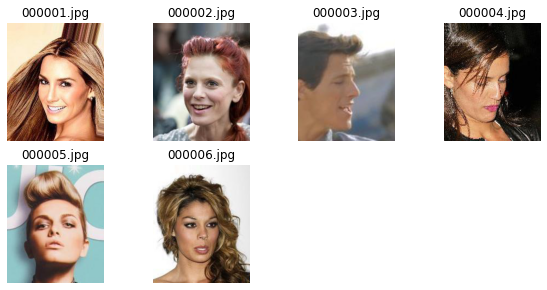

In [13]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:6]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [14]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    #X = (X - 127.5) / 127.5
    X = X / 255
    return X

dataset = get_data(images)

# Discriminator:

In [15]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# GENERATOR

In [16]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# GAN: 

In [17]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated,epoch, n=5):
    #[-1,1] -> [0,1] 
    #generated = (generated + 1)/ 2
    #generated = (generated[:n*n] * 127.5) + 127.5
    #generated = generated * 255
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)  

# TRAIN

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

C:\Users\Admin\anacondalastone\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch: 1,  Loss: D_real = 0.032, D_fake = 0.665,  G = 0.754
Epoch: 2,  Loss: D_real = 0.078, D_fake = 0.749,  G = 0.673
Epoch: 3,  Loss: D_real = 0.295, D_fake = 0.826,  G = 0.756
Epoch: 4,  Loss: D_real = 0.578, D_fake = 0.680,  G = 0.830
Epoch: 5,  Loss: D_real = 0.054, D_fake = 0.645,  G = 0.948
Epoch: 6,  Loss: D_real = 0.065, D_fake = 0.517,  G = 1.064
Epoch: 7,  Loss: D_real = 1.254, D_fake = 9.147,  G = 0.186
Epoch: 8,  Loss: D_real = 0.184, D_fake = 0.592,  G = 1.230
Epoch: 9,  Loss: D_real = 0.177, D_fake = 0.531,  G = 1.078
Epoch: 10,  Loss: D_real = 0.001, D_fake = 0.043,  G = 4.371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 100%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

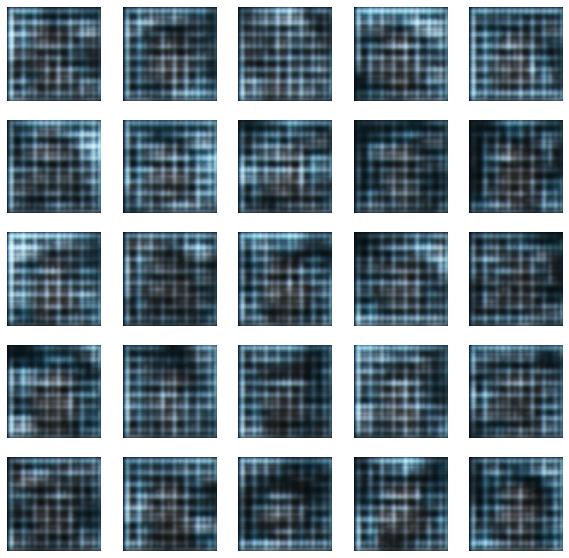

Epoch: 11,  Loss: D_real = 0.131, D_fake = 0.732,  G = 0.928
Epoch: 12,  Loss: D_real = 0.000, D_fake = 0.077,  G = 2.914
Epoch: 13,  Loss: D_real = 0.727, D_fake = 1.382,  G = 0.635
Epoch: 14,  Loss: D_real = 0.374, D_fake = 0.414,  G = 1.476
Epoch: 15,  Loss: D_real = 0.167, D_fake = 0.280,  G = 2.002
Epoch: 16,  Loss: D_real = 0.423, D_fake = 0.248,  G = 2.444
Epoch: 17,  Loss: D_real = 0.404, D_fake = 0.543,  G = 1.504
Epoch: 18,  Loss: D_real = 1.040, D_fake = 1.058,  G = 0.911
Epoch: 19,  Loss: D_real = 0.808, D_fake = 0.562,  G = 1.179
Epoch: 20,  Loss: D_real = 0.559, D_fake = 0.526,  G = 1.696
>Accuracy [real: 84%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

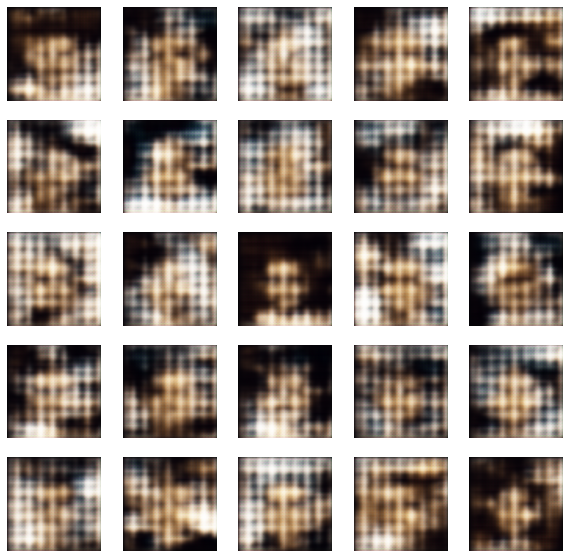

Epoch: 21,  Loss: D_real = 0.595, D_fake = 0.635,  G = 1.021
Epoch: 22,  Loss: D_real = 0.625, D_fake = 0.603,  G = 0.941
Epoch: 23,  Loss: D_real = 0.519, D_fake = 0.524,  G = 1.217
Epoch: 24,  Loss: D_real = 0.486, D_fake = 0.609,  G = 1.215
Epoch: 25,  Loss: D_real = 0.346, D_fake = 0.520,  G = 1.407
Epoch: 26,  Loss: D_real = 0.651, D_fake = 0.653,  G = 1.023
Epoch: 27,  Loss: D_real = 0.519, D_fake = 0.661,  G = 0.999
Epoch: 28,  Loss: D_real = 0.484, D_fake = 0.578,  G = 1.152
Epoch: 29,  Loss: D_real = 0.582, D_fake = 0.519,  G = 1.171
Epoch: 30,  Loss: D_real = 0.437, D_fake = 0.552,  G = 1.525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 78%, fake: 49%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

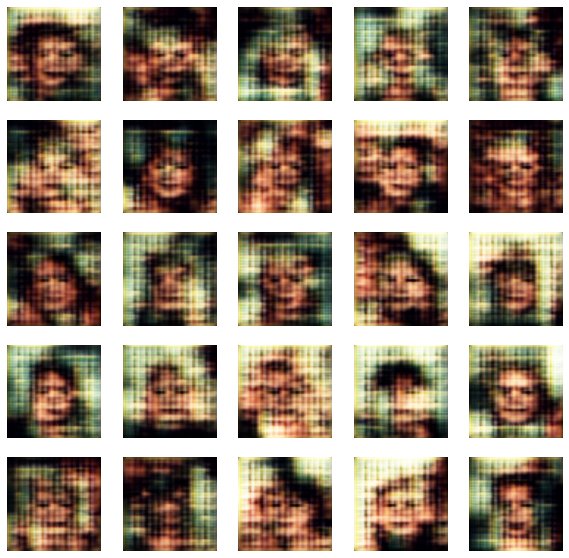

Epoch: 31,  Loss: D_real = 0.678, D_fake = 0.523,  G = 1.225
Epoch: 32,  Loss: D_real = 0.537, D_fake = 0.603,  G = 1.145
Epoch: 33,  Loss: D_real = 0.430, D_fake = 0.465,  G = 1.547
Epoch: 34,  Loss: D_real = 0.557, D_fake = 0.713,  G = 1.510
Epoch: 35,  Loss: D_real = 0.638, D_fake = 0.543,  G = 1.400
Epoch: 36,  Loss: D_real = 0.331, D_fake = 0.395,  G = 2.072
Epoch: 37,  Loss: D_real = 0.719, D_fake = 0.820,  G = 1.569
Epoch: 38,  Loss: D_real = 0.288, D_fake = 0.629,  G = 1.877
Epoch: 39,  Loss: D_real = 0.600, D_fake = 0.647,  G = 1.054
Epoch: 40,  Loss: D_real = 0.693, D_fake = 0.588,  G = 1.077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 43%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

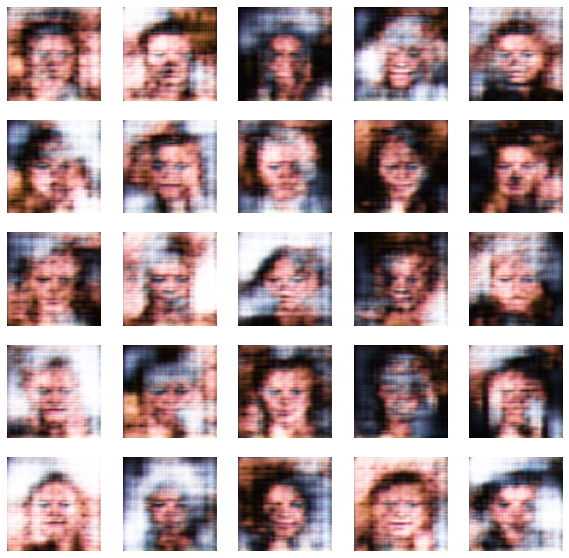

Epoch: 41,  Loss: D_real = 0.676, D_fake = 0.622,  G = 1.142
Epoch: 42,  Loss: D_real = 0.620, D_fake = 0.610,  G = 0.981
Epoch: 43,  Loss: D_real = 0.636, D_fake = 0.573,  G = 1.289
Epoch: 44,  Loss: D_real = 0.377, D_fake = 0.585,  G = 1.450
Epoch: 45,  Loss: D_real = 0.446, D_fake = 0.520,  G = 1.553
Epoch: 46,  Loss: D_real = 0.455, D_fake = 0.467,  G = 1.841
Epoch: 47,  Loss: D_real = 0.578, D_fake = 0.462,  G = 1.675
Epoch: 48,  Loss: D_real = 0.490, D_fake = 0.517,  G = 1.781
Epoch: 49,  Loss: D_real = 0.572, D_fake = 0.497,  G = 2.017
Epoch: 50,  Loss: D_real = 0.562, D_fake = 0.472,  G = 1.897


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 71%, fake: 87%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

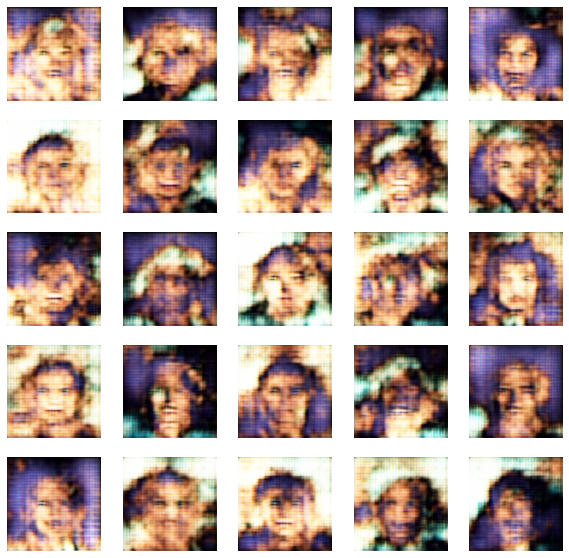

Epoch: 51,  Loss: D_real = 0.449, D_fake = 0.495,  G = 1.612
Epoch: 52,  Loss: D_real = 0.467, D_fake = 0.617,  G = 1.786
Epoch: 53,  Loss: D_real = 0.432, D_fake = 0.415,  G = 1.447
Epoch: 54,  Loss: D_real = 0.525, D_fake = 0.448,  G = 1.819
Epoch: 55,  Loss: D_real = 0.389, D_fake = 0.306,  G = 2.233
Epoch: 56,  Loss: D_real = 1.944, D_fake = 0.351,  G = 1.385
Epoch: 57,  Loss: D_real = 0.394, D_fake = 0.483,  G = 1.804
Epoch: 58,  Loss: D_real = 0.448, D_fake = 0.516,  G = 1.933
Epoch: 59,  Loss: D_real = 0.330, D_fake = 0.343,  G = 2.727
Epoch: 60,  Loss: D_real = 0.518, D_fake = 0.693,  G = 1.297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 73%, fake: 87%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

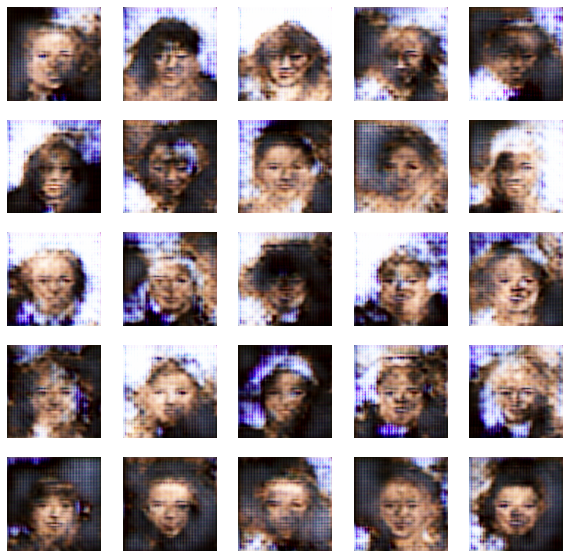

Epoch: 61,  Loss: D_real = 0.638, D_fake = 0.400,  G = 1.760
Epoch: 62,  Loss: D_real = 0.560, D_fake = 0.490,  G = 2.283
Epoch: 63,  Loss: D_real = 0.460, D_fake = 0.312,  G = 2.678
Epoch: 64,  Loss: D_real = 0.390, D_fake = 0.394,  G = 1.966
Epoch: 65,  Loss: D_real = 0.835, D_fake = 0.151,  G = 2.488
Epoch: 66,  Loss: D_real = 0.318, D_fake = 0.359,  G = 3.240
Epoch: 67,  Loss: D_real = 0.291, D_fake = 0.203,  G = 2.915
Epoch: 68,  Loss: D_real = 0.416, D_fake = 0.338,  G = 2.585
Epoch: 69,  Loss: D_real = 0.375, D_fake = 0.300,  G = 2.884
Epoch: 70,  Loss: D_real = 0.315, D_fake = 0.376,  G = 3.372


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 85%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

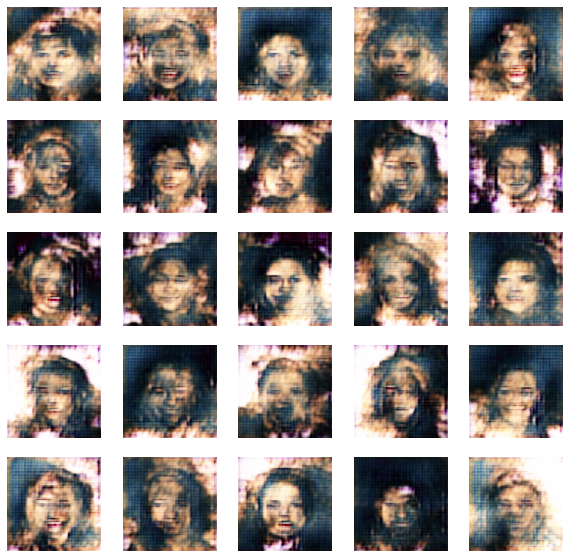

Epoch: 71,  Loss: D_real = 0.908, D_fake = 0.766,  G = 2.659
Epoch: 72,  Loss: D_real = 0.366, D_fake = 0.436,  G = 3.674
Epoch: 73,  Loss: D_real = 0.391, D_fake = 0.544,  G = 3.174
Epoch: 74,  Loss: D_real = 0.392, D_fake = 0.167,  G = 2.810
Epoch: 75,  Loss: D_real = 0.479, D_fake = 0.253,  G = 3.300
Epoch: 76,  Loss: D_real = 0.275, D_fake = 0.332,  G = 3.732
Epoch: 77,  Loss: D_real = 0.923, D_fake = 0.288,  G = 2.019
Epoch: 78,  Loss: D_real = 0.445, D_fake = 0.381,  G = 2.731
Epoch: 79,  Loss: D_real = 0.465, D_fake = 0.297,  G = 2.236
Epoch: 80,  Loss: D_real = 0.306, D_fake = 0.340,  G = 2.947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 85%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

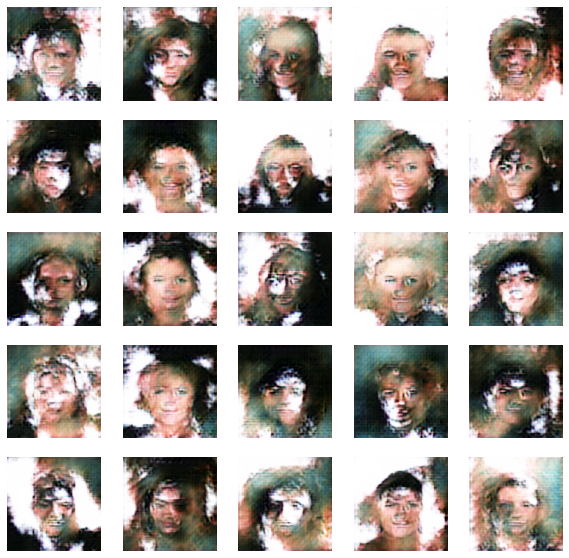

Epoch: 81,  Loss: D_real = 0.282, D_fake = 0.270,  G = 3.189
Epoch: 82,  Loss: D_real = 0.298, D_fake = 0.305,  G = 2.836
Epoch: 83,  Loss: D_real = 0.358, D_fake = 0.309,  G = 2.838
Epoch: 84,  Loss: D_real = 0.387, D_fake = 0.316,  G = 3.369
Epoch: 85,  Loss: D_real = 0.330, D_fake = 0.400,  G = 3.445
Epoch: 86,  Loss: D_real = 0.306, D_fake = 0.298,  G = 3.292
Epoch: 87,  Loss: D_real = 0.469, D_fake = 0.220,  G = 2.703
Epoch: 88,  Loss: D_real = 0.357, D_fake = 0.299,  G = 3.267
Epoch: 89,  Loss: D_real = 0.280, D_fake = 0.322,  G = 3.992
Epoch: 90,  Loss: D_real = 0.368, D_fake = 0.357,  G = 2.035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 91%, fake: 96%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

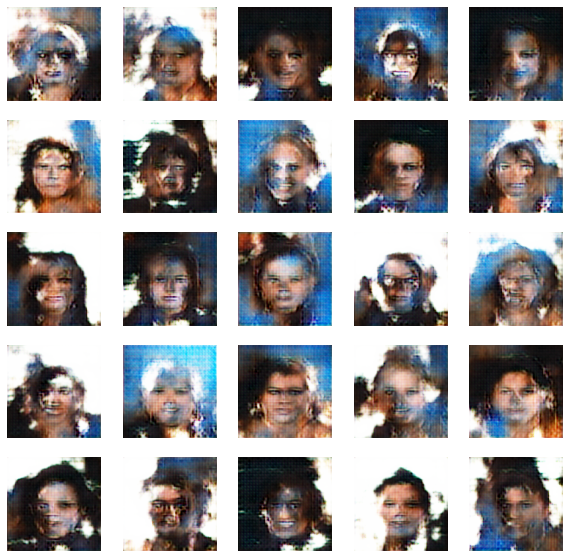

Epoch: 91,  Loss: D_real = 0.632, D_fake = 0.400,  G = 3.306
Epoch: 92,  Loss: D_real = 0.403, D_fake = 0.655,  G = 3.343
Epoch: 93,  Loss: D_real = 0.190, D_fake = 0.313,  G = 3.551
Epoch: 94,  Loss: D_real = 0.524, D_fake = 0.476,  G = 2.854
Epoch: 95,  Loss: D_real = 0.264, D_fake = 0.613,  G = 2.033
Epoch: 96,  Loss: D_real = 0.234, D_fake = 0.571,  G = 2.606
Epoch: 97,  Loss: D_real = 0.321, D_fake = 0.373,  G = 2.406
Epoch: 98,  Loss: D_real = 0.341, D_fake = 0.412,  G = 2.714
Epoch: 99,  Loss: D_real = 0.544, D_fake = 0.481,  G = 2.280
Epoch: 100,  Loss: D_real = 0.421, D_fake = 0.498,  G = 3.302


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 87%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

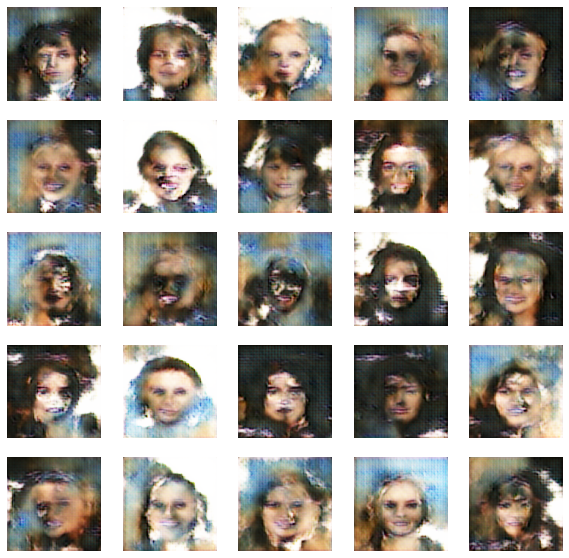

Total time for training 100 epochs is 341249.28119564056 sec


In [19]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

## TODO: Get better output images!


# Check how generated images by GAN Model every 10 epochs improve definition and get closer to the real ones. We could have added more epochs, approximately 1000, and the generated images would even get closer in definition to the real ones!